In [402]:
# Start by importing necessary packages
import warnings
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels import PanelOLS # pip install linearmodels
from IPython.display import display
from io import StringIO

from dstapi import DstApi # The helper class. pip install git+https://github.com/alemartinello/dstapi

**Alternative to using DstApi:**

In [2]:
# Directly embed parameters in the URL with response.get()
requests.get('https://api.statbank.dk/v1' + '/tableinfo' + "?id=NAN1&format=JSON").json()

# Pass a dictionary of parameters to requests.get()
params = {'id': 'NAN1', 'format': 'JSON'}
requests.get('https://api.statbank.dk/v1' + '/tableinfo', params=params).json()

# Use response.post() - note the change in the name of the parameter about the table's name
# I'm also adding here a language parameter - most tables are available in both Danish and English
params = {'table': 'NAN1', 'format': 'JSON', 'lang':'en'}
requests.post('https://api.statbank.dk/v1' + '/tableinfo', json=params).json()

{'id': 'NAN1',
 'text': 'Demand and supply',
 'description': 'Demand and supply by transaction, price unit and time',
 'unit': '-',
 'suppressedDataValue': '0',
 'updated': '2023-03-31T08:00:00',
 'active': True,
 'contacts': [{'name': 'Bo Siemsen',
   'phone': '39173069',
   'mail': 'bsm@dst.dk'}],
 'documentation': {'id': '0cf24458-15d1-486d-ad2d-8f4d16dd37ad',
  'url': 'https://www.dst.dk/documentationofstatistics/0cf24458-15d1-486d-ad2d-8f4d16dd37ad'},
 'footnote': {'text': 'Chained values do not show additivity. By chained values you cannot find totals by simple addition of components. You need to use a specific formula as described here - https://www.dst.dk/ext/national/NR-DOK.',
  'mandatory': True},
 'variables': [{'id': 'TRANSAKT',
   'text': 'transaction',
   'elimination': False,
   'time': False,
   'values': [{'id': 'B1GQK', 'text': 'B.1*g Gross domestic product'},
    {'id': 'P7K', 'text': 'P.7 Imports of goods and services'},
    {'id': 'P71K', 'text': 'P.71 Import of go

**Using DstApi (pip install git+https://github.com/alemartinello/dstapi):**

In [3]:
# Initialize the class with the target tables
NationalAccount = DstApi('NAN1')                # Unit : 2010-prices, chained values, bill DKK
EmploymentPopuplation = DstApi('NAHB')          # Unit : number of people
Capital = DstApi('NAHD34')                      # Unit : m DKK
Unemployment = DstApi('AULAAR')                 # Unit : % of labour force

Income = DstApi('INDKP201')                     # Unit : DKK, fixed prices
Wealth = DstApi('FORMUE11')                     # Unit : DKK, fixed prices / Using 2014-definiion of net-wealth

FirstYear = 2000                                # Define first year of data (in cases where prior data exists)

## National account

In [4]:
display(NationalAccount.variable_levels('TRANSAKT', language='en'))

,id,text
0,B1GQK,B.1*g Gross domestic product
1,P7K,P.7 Imports of goods and services
2,P71K,P.71 Import of goods
3,P72K,P.72 Import of services
4,TFSPR,Supply
5,P6D,P.6 Exports of goods and services
6,P61D,P.61 Export of goods
7,P62D,P.62 Export of services
8,P31S1MD,P.31 Private consumption
9,P31S14D,P.31 Household consumption expenditure


**Define variables of interest:**

In [5]:
params = {
    'table': 'NAN1',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B1GQK','P7K','P6D','P31S1MD','P3S13D','P5GD']},    # (GDP, imports of goods and services, exports of goods and services, private consumption, government consumption expenditure, gross capital formation (investments))
        {'code': 'PRISENHED', 'values': ['LAN_M']},                                         # 2010-prices, chained values (bill. DKK)
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}                                      # specified years    
        ]
    }
SupplyBalanceVar = NationalAccount.get_data(params=params).set_index(['TID']).sort_values(['TID'])

**Create dataframe:**

In [6]:
SupplyBalanceDF = pd.DataFrame()
SupplyBalanceDF['Y'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'B.1*g Gross domestic product'].copy()
SupplyBalanceDF['M'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.7 Imports of goods and services'].copy()
SupplyBalanceDF['X'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.6 Exports of goods and services'].copy()
SupplyBalanceDF['C'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.31 Private consumption'].copy()
SupplyBalanceDF['G'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.3 Government consumption expenditure'].copy()
SupplyBalanceDF['I'] = SupplyBalanceVar[['INDHOLD']].loc[SupplyBalanceVar['TRANSAKT'] == 'P.5g Gross capital formation'].copy()
SupplyBalanceDF = SupplyBalanceDF.apply(pd.to_numeric)
SupplyBalanceDF['M_ratio'] = SupplyBalanceDF['M']/SupplyBalanceDF['Y']
SupplyBalanceDF['X_ratio'] = SupplyBalanceDF['X']/SupplyBalanceDF['Y'] 
SupplyBalanceDF['C_ratio'] = SupplyBalanceDF['C']/SupplyBalanceDF['Y'] 
SupplyBalanceDF['G_ratio'] = SupplyBalanceDF['G']/SupplyBalanceDF['Y']
SupplyBalanceDF['I_ratio'] = SupplyBalanceDF['I']/SupplyBalanceDF['Y'] 

In [7]:
SupplyBalanceDF

,Y,M,X,C,G,I,M_ratio,X_ratio,C_ratio,G_ratio,I_ratio
TID,,,,,,,,,,,
2000,1677.2,548.7,696.9,752.6,412.2,348.2,0.327152,0.415514,0.448724,0.245767,0.207608
2001,1691.0,561.9,720.3,754.3,420.0,343.0,0.332289,0.425961,0.446067,0.248374,0.202839
2002,1698.9,597.7,751.7,765.2,429.0,338.9,0.351816,0.442463,0.450409,0.252516,0.199482
2003,1705.5,591.6,742.7,775.4,430.0,336.6,0.346878,0.435473,0.454647,0.252125,0.197361
2004,1751.0,633.8,765.1,811.5,436.6,359.4,0.361965,0.436950,0.463449,0.249343,0.205254
2005,1792.0,705.3,824.2,841.5,441.8,379.3,0.393583,0.459933,0.469587,0.246540,0.211663
2006,1862.1,803.9,909.4,866.3,453.1,427.7,0.431717,0.488373,0.465227,0.243327,0.229687
2007,1879.0,850.8,942.6,881.6,458.5,439.1,0.452794,0.501650,0.469186,0.244013,0.233688
2008,1869.4,891.4,979.1,885.9,473.4,418.0,0.476837,0.523751,0.473895,0.253236,0.223601


## Capital, employment and population

**Employment and population:**

In [8]:
display(EmploymentPopuplation.variable_levels('SOCIO', language='en'))

,id,text
0,EMPM_DC,Employment (number)
1,EMPM_NC,"Employment, national concept"
2,POP,Population


**Define variables of interest:**

In [9]:
params = {
    'table': 'NAHB',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'SOCIO', 'values': ['EMPM_DC','POP']},     # employment (number) and population
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
EmploymentPopuplationVar = EmploymentPopuplation.get_data(params=params).sort_values(['TID'])

**Capital:**

**Define variables of interest:**

In [10]:
params = {
    'table': 'NAHD34',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B8GK']},           # gross savings
        {'code': 'Tid', 'values': [f'>={FirstYear}<']}      # specified years
        ]
    }
CapitalVar = Capital.get_data(params=params).sort_values(['TID'])


**Create dataframe:**

In [11]:
CapitalEmploymentPopuplationDF = pd.DataFrame()
CapitalEmploymentPopuplationDF['L'] = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Employment (number)'].copy().set_index(['TID'])
CapitalEmploymentPopuplationDF['N'] = EmploymentPopuplationVar[['TID','INDHOLD']].loc[EmploymentPopuplationVar['SOCIO'] == 'Population'].copy().set_index(['TID'])
CapitalEmploymentPopuplationDF['K'] = CapitalVar[['TID','INDHOLD']].loc[CapitalVar['TRANSAKT'] == 'B.8g Saving, gross'].copy().set_index(['TID'])
CapitalEmploymentPopuplationDF = CapitalEmploymentPopuplationDF.apply(pd.to_numeric)
CapitalEmploymentPopuplationDF['L_ratio'] = CapitalEmploymentPopuplationDF['L']/CapitalEmploymentPopuplationDF['N'] 

In [12]:
CapitalEmploymentPopuplationDF

,L,N,K,L_ratio
TID,,,,
2000,2755149,5338491,318423.0,0.516091
2001,2782473,5357285,343436.0,0.519381
2002,2784200,5375575,343526.0,0.517935
2003,2758653,5389521,351281.0,0.511855
2004,2744153,5403040,374174.0,0.507891
2005,2783163,5418559,418680.0,0.513635
2006,2845937,5436756,464694.0,0.523462
2007,2912410,5460399,464702.0,0.533369
2008,2946869,5492726,484618.0,0.536504


## Unemployment rate

**Define variables of interest:**

In [13]:
params = {
    'table': 'AULAAR',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'KØN', 'values': ['TOT']},                             # men and women in total
        {'code': 'PERPCT', 'values': ['L10']},                          # percent of the labour force 
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}                   # specified years
        ]
    }
UnemploymentVar = Unemployment.get_data(params=params).set_index(['TID']).sort_values(['TID'])

**Create dataframe:**

In [14]:
UnemploymentDF = pd.DataFrame()
UnemploymentDF['U'] = UnemploymentVar[['INDHOLD']].loc[UnemploymentVar['PERPCT'] == 'Per cent of the labour force'].copy()
UnemploymentDF = UnemploymentDF.apply(pd.to_numeric)

## Income and wealth lifecycles

**Income:**

**Define variables of interest:**

In [15]:
Income.tablesummary(language='en')

Table INDKP201: Main table for personal income statistics by type of income, sex, age, population, price unit, unit and time
Last update: 2022-11-24T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,INDKOMSTTYPE,39,100,1 Disposable income (2+30-31-32-35),290,Taxable income,False
1,KOEN,3,MOK,"Men and women, total",K,Women,False
2,ALDER,15,14TOT,"Total, 15 years and over",80-00,80 years and over,False
3,POPU,2,5000,All regardless of having the type of income,5020,Only people with the type of income,False
4,PRISENHED,2,005,Constant prices,006,Nominal prices,False
5,ENHED,5,0050,Mean (DKK),105,People (Number),False
6,Tid,26,1996,1996,2021,2021,True


In [16]:
params = {
    'table': 'INDKP201',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'INDKOMSTTYPE', 'values': ['100']},                        # disposable income (Pre-tax income is 105) 
        {'code': 'KOEN', 'values': ['MOK']},                                # men and women in total
        {'code': 'ALDER', 'values': ['*']},	                                # all ages
        {'code': 'POPU', 'values': ['5000']},	                            # all regardless of having the type of income
        {'code': 'PRISENHED', 'values': ['005']},                           # fixed prices (latest data years price level - 2021)
        {'code': 'ENHED', 'values': ['0050']},                              # average DKK
        {'code': 'Tid', 'values':[f'>={FirstYear}<']}
        ]
    }
DisposableIncomeVar = Income.get_data(params=params).sort_values(['TID'])

**Wealth**:

**Define variables of interest:**

In [17]:
Wealth.tablesummary(language='en')

Table FORMUE11: Wealth by type of wealth, unit, age, sex, population and time
Last update: 2022-12-20T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,FORM1,46,FGNF2020,"Net Wealth, (2020-definition A+B+CX-D-E-F)",FGF4,F.4. Other debt to the public sector,False
1,ENHED,9,200,Median (Constant prices 2021-level),240,Number of people in population 31.12,False
2,ALDER,16,1802,18 years and over,9099,90 years and over,False
3,KØN,3,MOK,"Men and women, total",K,Women,False
4,POPU,2,5005,Entire population,5025,Only people with the selected type of wealth,False
5,Tid,8,2014,2014,2021,2021,True


In [18]:
params = {
    'table': 'FORMUE11',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'FORM1', 'values': ['FGNF2014']},              # net wealth (2014 definition: Real assets + Financial asset excluding unquoted shares + Pensions in total - Mortgage debt - Other loans - Study loans + Debt collection)
        {'code': 'ENHED', 'values': ['215']},                   # fixed prices - 2021
        {'code': 'ALDER', 'values': ['*']},	                    # all ages
        {'code': 'KØN', 'values': ['MOK']},                     # men and women in total
        {'code': 'POPU', 'values': ['5005']},	                # entire population	
        {'code': 'Tid', 'values':[f'>=2014<']}                  # first year for the data set is 2014
        ]
    }
WealthVar = Wealth.get_data(params=params).sort_values(['TID'])

**Create dataframe:**

In [425]:
IncomeDF = pd.crosstab(index=[DisposableIncomeVar['TID']],values = DisposableIncomeVar['INDHOLD'], aggfunc = sum, columns = str('DisInc: ') + DisposableIncomeVar['ALDER'])  # convert unique ages as columns for income
WealthDF = pd.crosstab(index=[WealthVar['TID']],values = WealthVar['INDHOLD'], aggfunc = sum, columns = str('Wealth: ') + WealthVar['ALDER'])                                # convert unique ages as columns for wealth
IncomeWealthDF =  pd.concat([IncomeDF,WealthDF], axis=1)                                                                                                                       # concatenate dataframes
IncomeWealthDF

ALDER,DisInc: 15-19 years,DisInc: 20-24 years,DisInc: 25-29 years,DisInc: 30-34 years,DisInc: 35-39 years,DisInc: 40-44 years,DisInc: 45-49 years,DisInc: 50-54 years,DisInc: 55-59 years,DisInc: 60-64 years,...,Wealth: 45-49 years,Wealth: 50-54 years,Wealth: 55-59 years,Wealth: 60-64 years,Wealth: 65-69 years,Wealth: 70-74 years,Wealth: 75-79 years,Wealth: 80-84 years,Wealth: 85-89 years,Wealth: 90 years and over
TID,,,,,,,,,,,,,,,,,,,,,
2000,37000,121400,171500,209100,227400,233800,235500,236100,229700,201100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,36400,121000,171100,209400,229700,237000,237300,239200,234200,204600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,38300,121100,170900,210600,232100,241100,240400,240400,236700,208400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,37200,119500,170100,211800,233900,243900,242900,241000,240100,212600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,37100,122000,176400,222300,246400,256100,256900,254200,253900,224700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,37400,123100,177800,225200,250600,262700,263500,261000,262000,234600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,39600,125800,178600,226600,253800,267600,270400,267200,268300,243300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,41300,129100,180000,227100,254700,269700,272100,269600,270800,245800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,40600,127500,176700,220100,246300,259700,260100,259300,255900,233700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Steady state values

In [20]:
frames = [SupplyBalanceDF, CapitalEmploymentPopuplationDF, UnemploymentDF, IncomeWealthDF]

In [21]:
All_variables =  pd.concat(frames, axis=1)
All_variables

,Y,M,X,C,G,I,M_ratio,X_ratio,C_ratio,G_ratio,...,Wealth: 45-49 years,Wealth: 50-54 years,Wealth: 55-59 years,Wealth: 60-64 years,Wealth: 65-69 years,Wealth: 70-74 years,Wealth: 75-79 years,Wealth: 80-84 years,Wealth: 85-89 years,Wealth: 90 years and over
TID,,,,,,,,,,,,,,,,,,,,,
2000,1677.2,548.7,696.9,752.6,412.2,348.2,0.327152,0.415514,0.448724,0.245767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,1691.0,561.9,720.3,754.3,420.0,343.0,0.332289,0.425961,0.446067,0.248374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,1698.9,597.7,751.7,765.2,429.0,338.9,0.351816,0.442463,0.450409,0.252516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,1705.5,591.6,742.7,775.4,430.0,336.6,0.346878,0.435473,0.454647,0.252125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,1751.0,633.8,765.1,811.5,436.6,359.4,0.361965,0.436950,0.463449,0.249343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,1792.0,705.3,824.2,841.5,441.8,379.3,0.393583,0.459933,0.469587,0.246540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,1862.1,803.9,909.4,866.3,453.1,427.7,0.431717,0.488373,0.465227,0.243327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,1879.0,850.8,942.6,881.6,458.5,439.1,0.452794,0.501650,0.469186,0.244013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,1869.4,891.4,979.1,885.9,473.4,418.0,0.476837,0.523751,0.473895,0.253236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
mean_dict = {}
means = All_variables.mean()
for i,mean in enumerate(means):
    print(f'{means.index[i]}: {mean:.2f}')
    mean_dict[str(means.index[i])] = mean

Y: 1897.43
M: 867.53
X: 994.87
C: 880.64
G: 482.24
I: 402.13
M_ratio: 0.45
X_ratio: 0.52
C_ratio: 0.46
G_ratio: 0.25
I_ratio: 0.21
L: 2862658.48
N: 5588587.61
K: 510030.82
L_ratio: 0.51
U: 3.93
DisInc: 15-19 years: 35631.82
DisInc: 20-24 years: 119990.91
DisInc: 25-29 years: 179540.91
DisInc: 30-34 years: 232027.27
DisInc: 35-39 years: 264286.36
DisInc: 40-44 years: 283577.27
DisInc: 45-49 years: 289922.73
DisInc: 50-54 years: 287222.73
DisInc: 55-59 years: 280840.91
DisInc: 60-64 years: 254472.73
DisInc: 65-69 years: 211950.00
DisInc: 70-74 years: 195500.00
DisInc: 75-79 years: 188922.73
DisInc: 80 years and over: 187131.82
DisInc: Total, 15 years and over: 220722.73
Wealth: 18 years and over: 1341652.62
Wealth: 18-24 years: 91134.25
Wealth: 25-29 years: 167126.00
Wealth: 30-34 years: 336701.25
Wealth: 35-39 years: 610634.62
Wealth: 40-44 years: 962552.00
Wealth: 45-49 years: 1322445.88
Wealth: 50-54 years: 1686390.75
Wealth: 55-59 years: 2109184.12
Wealth: 60-64 years: 2525833.75
Wea

## Regressing income data

**Set up data for regression:**

In [426]:
# log income for regression
log_IncomeDF = np.log(IncomeDF)

# drop total income column
log_IncomeDF.drop('DisInc: Total, 15 years and over', axis=1, inplace=True)

# rename columns
col_dict = {f'DisInc: {i}-{i+4} years' : f'age{i}-{i+4}' for i in range(15,75+1,5)}
log_IncomeDF = log_IncomeDF.rename(columns = {'DisInc: 80 years and over':'age80>='})
log_IncomeDF.rename(columns = col_dict, inplace=True)

log_IncomeDF

ALDER,age15-19,age20-24,age25-29,age30-34,age35-39,age40-44,age45-49,age50-54,age55-59,age60-64,age65-69,age70-74,age75-79,age80>=
TID,,,,,,,,,,,,,,
2000,10.518673,11.706846,12.052339,12.250568,12.334466,12.362221,12.369466,12.372011,12.344529,12.211558,12.031719,11.984802,11.967815,11.948596
2001,10.502324,11.703546,12.050003,12.252002,12.344529,12.375815,12.377080,12.385055,12.363931,12.228812,12.054668,11.999663,11.984178,11.972879
2002,10.553205,11.704372,12.048834,12.257716,12.354924,12.392967,12.390059,12.390059,12.374549,12.247215,12.075964,12.004568,11.997202,12.013701
2003,10.524064,11.691072,12.044142,12.263398,12.362649,12.404514,12.400405,12.392552,12.388811,12.267168,12.092904,12.013701,12.005791,12.008231
2004,10.521372,11.711776,12.080509,12.311783,12.414712,12.453323,12.456442,12.445877,12.444696,12.322521,12.135650,12.041787,12.029335,12.034691
2005,10.529426,11.720752,12.088415,12.324744,12.431613,12.478768,12.481809,12.472276,12.476100,12.365637,12.164730,12.071970,12.056992,12.070825
2006,10.586584,11.742449,12.092904,12.330942,12.444302,12.497249,12.507658,12.495753,12.499861,12.402051,12.198040,12.099044,12.079942,12.087289
2007,10.628618,11.768343,12.100712,12.333146,12.447842,12.505066,12.513925,12.504695,12.509136,12.412273,12.220961,12.118879,12.088977,12.101268
2008,10.611523,11.755872,12.082209,12.301837,12.414306,12.467282,12.468821,12.465741,12.452542,12.361794,12.167851,12.084470,12.055250,12.078239


**Long format:**

In [427]:
log_IncomeDF = log_IncomeDF.reset_index()
long_df = pd.melt(log_IncomeDF, id_vars="TID", var_name="age_group", value_name="log_income")
long_df

,TID,age_group,log_income
0,2000,age15-19,10.518673
1,2001,age15-19,10.502324
2,2002,age15-19,10.553205
3,2003,age15-19,10.524064
4,2004,age15-19,10.521372
...,...,...,...
303,2017,age80>=,12.231253
304,2018,age80>=,12.241440
305,2019,age80>=,12.284884
306,2020,age80>=,12.310883


**Add variables:**
- Age 
- Birth year
- Age squared  

In [428]:
# new variables
long_df['median_birth_year'] = 0
long_df['median_age_squared'] = 0
long_df['median_age'] = 0
long_df['id'] = 0

a = range(0,308+22,22)
b = range(17,82+5,5)

# the age of a group is the median age of that group, i.e. 17 for group age15-19
for i,j in zip(a,b):
    long_df.loc[i:i+22,['median_birth_year']] = long_df['TID'] - j
    long_df.loc[i:i+22,['median_age_squared']] = j**2
    long_df.loc[i:i+22,['median_age']] = j
    long_df.loc[i:i+22,['id']] = j

long_df.set_index(['id', 'TID'], inplace=True)

**Run regression:**

In [429]:
# dependent variable
dependent = long_df.log_income

# exogenous variables
exog = sm.add_constant(long_df[['median_birth_year','median_age_squared','median_age']])

In [430]:
mod = PanelOLS(dependent, exog, drop_absorbed=True)
res = mod.fit(cov_type='unadjusted')
res

Dep. Variable:,log_income,R-squared:,0.7842
Estimator:,PanelOLS,R-squared (Between):,0.7893
No. Observations:,308,R-squared (Within):,0.6612
Date:,"Mon, Apr 24 2023",R-squared (Overall):,0.7842
Time:,16:48:52,Log-likelihood,-10.099
Cov. Estimator:,Unadjusted,,
,,F-statistic:,368.29
Entities:,14,P-value,0.0000
Avg Obs:,22.000,Distribution:,"F(3,304)"
Min Obs:,22.000,,
Max Obs:,22.000,F-statistic (robust):,368.29


### Predicted vs. observed income in year:

In [431]:
year = 2010 # must be a year in the data, i.e. 2000-2021

**Predicted income:**

In [432]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((year-i)*res.params.median_birth_year + res.params.const + res.params.median_age*i + res.params.median_age_squared*i**2))

**Observed income:**

In [433]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df.index.get_level_values(1) == year, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2010,age15-19,10.460242,1993,289,17,34900.0
22,2010,age20-24,11.702719,1988,484,22,120900.0
27,2010,age25-29,12.109562,1983,729,27,181600.0
32,2010,age30-34,12.375815,1978,1024,32,237000.0
37,2010,age35-39,12.507658,1973,1369,37,270400.0
42,2010,age40-44,12.561297,1968,1764,42,285300.0
47,2010,age45-49,12.569326,1963,2209,47,287600.0
52,2010,age50-54,12.555673,1958,2704,52,283700.0
57,2010,age55-59,12.532855,1953,3249,57,277300.0


**Plot:**

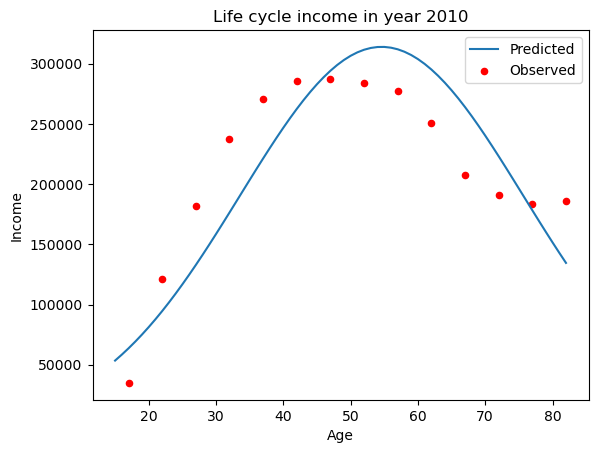

In [434]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income in year ' + str(year))
plt.ylabel('Income')
plt.xlabel('Age')
plt.legend()
plt.show()

### Predicted vs. observed income for cohort 1983:

**Predicted income for cohort 1983 (corrected for trend in time):**

In [435]:
pred_income = []
age = []

# loop over years with income
for i in range(15,82+1):
    age.append(i)
    pred_income.append(np.exp((1983)*res.params.median_birth_year + res.params.const + res.params.median_age*i + res.params.median_age_squared*i**2)) # birth year, 1983, remains constant

**Observed income for cohort 1983:**

In [436]:
warnings.filterwarnings('ignore')

obs_income = long_df.loc[long_df['median_birth_year'] == 1983, :]
obs_income['income'] = np.exp(obs_income['log_income'])
display(obs_income)

warnings.filterwarnings('default')

,,age_group,log_income,median_birth_year,median_age_squared,median_age,income
id,TID,,,,,,
17,2000,age15-19,10.518673,1983,289,17,37000.0
22,2005,age20-24,11.720752,1983,484,22,123100.0
27,2010,age25-29,12.109562,1983,729,27,181600.0
32,2015,age30-34,12.369466,1983,1024,32,235500.0
37,2020,age35-39,12.623796,1983,1369,37,303700.0


****

**Plot:**

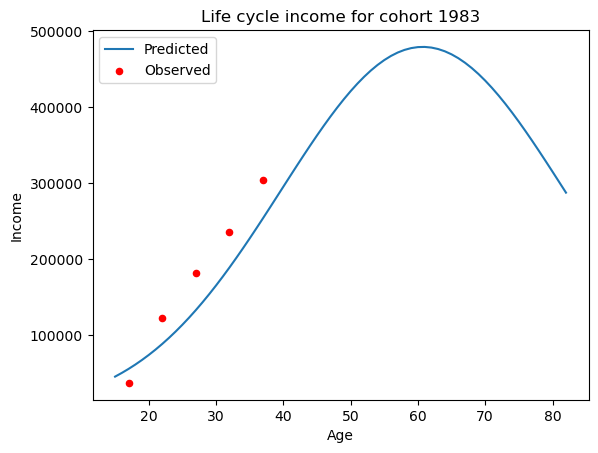

In [437]:
plt.plot(age, pred_income, label='Predicted')
obs_income.plot(kind='scatter', x='median_age', y='income', label='Observed', color='red', ax=plt.gca())

plt.title('Life cycle income for cohort 1983')
plt.ylabel('Income')
plt.xlabel('Age')
plt.legend()
plt.show()

## Wealth-income ratio:

**Calculate the wealth-income ratio based on the raw data:**

In [442]:
# get the relevant data frame
IncomeWealthDF =  pd.concat([IncomeDF,WealthDF], axis=1)

ages = []

# loop over age groups common to income and wealth data
for i in range(25,75+1,5):
    IncomeWealthDF['age_' + str(i) + '-' + str(i+4)] = IncomeWealthDF['Wealth: ' + str(i) + '-' + str(i+4) + ' years']/IncomeWealthDF['DisInc: ' + str(i) + '-' + str(i+4) + ' years']
    ages.append(i+2)

# the first age group, age_15-24
IncomeWealthDF['age_15-24'] = (IncomeWealthDF['DisInc: 15-19 years']+IncomeWealthDF['DisInc: 20-24 years'])/IncomeWealthDF['Wealth: 18-24 years'] # assuming no wealth for 15-17 years - no data ...
ages = [20] + ages

# wealth-income ratio for all age groups
IncomeWealthDF = IncomeWealthDF[['age_15-24']+['age_' + str(i) + '-' + str(i+4) for i in range(25,75+1,5)]]
IncomeWealthDF = IncomeWealthDF.dropna() # drop NANs - wealth data only available for 2014-2021

# take the mean over time for each age group
wealth_income_ratio = IncomeWealthDF.mean()
print(wealth_income_ratio)

ALDER
age_15-24     1.708060
age_25-29     0.890411
age_30-34     1.353253
age_35-39     2.105396
age_40-44     3.002130
age_45-49     3.944670
age_50-54     5.090315
age_55-59     6.610407
age_60-64     8.627028
age_65-69    10.806958
age_70-74    10.706063
age_75-79     9.618272
dtype: float64


**Linear interpolation of the observed wealth-income ratio:**

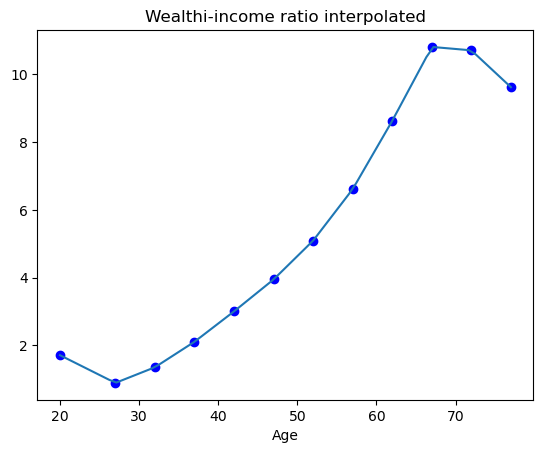

In [443]:
wealth_income_ratio = wealth_income_ratio.tolist()

ages_ = np.linspace(min(ages), max(ages), num=65) # num=65 => one dot for each age in 15-79
wealth_inc_interp = np.interp(ages_, ages, wealth_income_ratio)

plt.title('Wealth-income ratio interpolated')
plt.plot(ages, wealth_income_ratio, 'bo')
plt.plot(ages_, wealth_inc_interp)
plt.xlabel('Age')
plt.show()